<a href="https://colab.research.google.com/github/mehang/Improvised-CNN/blob/master/notebook/Caltech-256/resized/15*15/caltech256_15_15.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pathlib
import time

from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [ ]:
!unzip /content/drive/My\ Drive/Mehang\ Rai/caltech-256-image.zip -d caltech-256-image

In [4]:
ITERATION = 5
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
RANDOM_SEED = [42,42,34,56,62,74,29,15,7,81][ITERATION-1]
BATCH_SIZE = 32
NUM_CLASSES = 257
EPOCHS = 1000
GABOR_LAYER_INDEX = 0
GABOR_WIDTH = 15
GABOR_HEIGHT = 15
GABOR_SIZE = (GABOR_WIDTH, GABOR_HEIGHT)
NUM_RECEPTIVE_FILTERS = 64

In [5]:
filenames = os.listdir("caltech-256-image/caltech-256-image/")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [6]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=RANDOM_SEED)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]

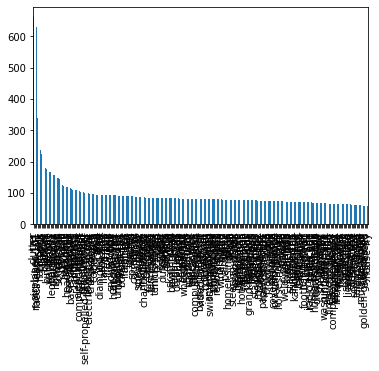

In [7]:
train_df['category'].value_counts().plot.bar()

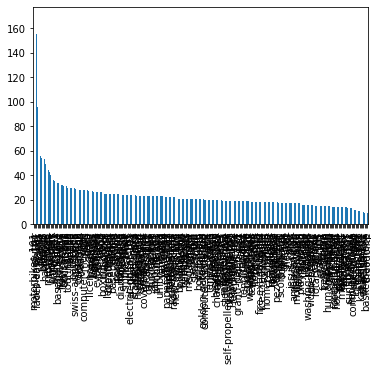

In [8]:
validate_df['category'].value_counts().plot.bar()

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    rescale=1./255,
)
train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "caltech-256-image/caltech-256-image/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 24485 validated image filenames belonging to 257 classes.


In [10]:
validation_datagen = ImageDataGenerator(
    fill_mode='nearest',
    rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "caltech-256-image/caltech-256-image/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=BATCH_SIZE
)

Found 6122 validated image filenames belonging to 257 classes.


In [11]:
# Importing the Keras libraries and packages
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Activation
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

classifier = None
classifier = Sequential([
    layers.Conv2D(NUM_RECEPTIVE_FILTERS, kernel_size=GABOR_SIZE, strides=(1,1), padding='same', activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(128, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(256, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Conv2D(512, kernel_size=(3,3), padding='same', strides=(1,1), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(4096, activation='relu'),
    layers.BatchNormalization(),
    Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      43264     
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10,  
                              min_delta=1e-4, mode='min', verbose=1)
stop_alg = EarlyStopping(monitor='val_loss', patience=35, 
                         restore_best_weights=True, verbose=1)
callbacks = [stop_alg, reduce_lr]
opt = Adam(learning_rate=0.001)
classifier.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', 'AUC'])

start = time.perf_counter()
hist = classifier.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=total_validate//BATCH_SIZE,
    steps_per_epoch=total_train//BATCH_SIZE,
    callbacks=callbacks
)
finish = time.perf_counter()

Epoch 1/1000
765/765 [==============================] - 432s 556ms/step - loss: 7.9303 - accuracy: 0.0212 - auc: 0.5513 - val_loss: 8.5731 - val_accuracy: 0.0438 - val_auc: 0.5865
Epoch 2/1000
765/765 [==============================] - 423s 553ms/step - loss: 7.6639 - accuracy: 0.0409 - auc: 0.6016 - val_loss: 8.1115 - val_accuracy: 0.0754 - val_auc: 0.6427
Epoch 3/1000
765/765 [==============================] - 425s 556ms/step - loss: 7.1461 - accuracy: 0.0608 - auc: 0.6477 - val_loss: 7.6574 - val_accuracy: 0.0623 - val_auc: 0.6605
Epoch 4/1000
765/765 [==============================] - 423s 553ms/step - loss: 6.7602 - accuracy: 0.0718 - auc: 0.6723 - val_loss: 8.1966 - val_accuracy: 0.0686 - val_auc: 0.6682
Epoch 5/1000
765/765 [==============================] - 425s 555ms/step - loss: 6.4472 - accuracy: 0.0817 - auc: 0.6871 - val_loss: 9.8982 - val_accuracy: 0.0854 - val_auc: 0.7031
Epoch 6/1000
765/765 [==============================] - 424s 554ms/step - loss: 5.9924 - accuracy: 0

In [13]:
print("Start time = {}".format(start))
print("Finish time = {}".format(finish))
print("Training time = {}".format(finish-start))
hist.history['start_time'] = start
hist.history['finish_time'] = finish
hist.history['train_time'] = finish-start

Start time = 555.965540164
Finish time = 21333.157398581
Training time = 20777.191858416998


In [14]:
import pickle

with open('caltech256-{}-history-kernel-{}.p'.format(ITERATION, GABOR_WIDTH),'wb') as fp:
    pickle.dump(hist.history, fp, protocol=pickle.HIGHEST_PROTOCOL)

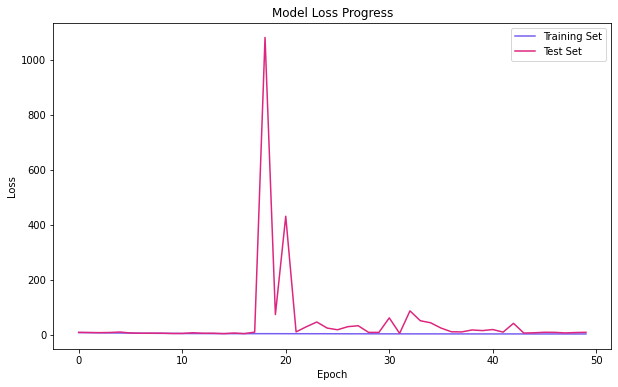

In [15]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['loss'], color='#785ef0')
plt.plot(hist.history['val_loss'], color='#dc267f')
plt.title('Model Loss Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-loss-kernel-{}.png'.format(ITERATION,GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

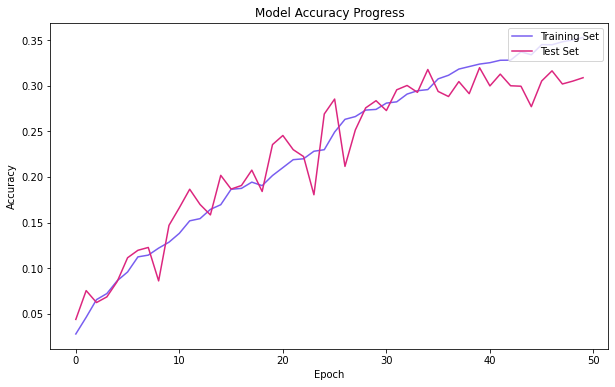

In [16]:
fig = plt.figure(figsize=(10,6))
plt.plot(hist.history['accuracy'], color='#785ef0')
plt.plot(hist.history['val_accuracy'], color='#dc267f')
plt.title('Model Accuracy Progress')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Set', 'Test Set'], loc='upper right')
plt.savefig('caltech256-{}-accuracy-kernel-{}.png'.format(ITERATION, GABOR_WIDTH), dpi=350, bbox_inches='tight')
plt.show()

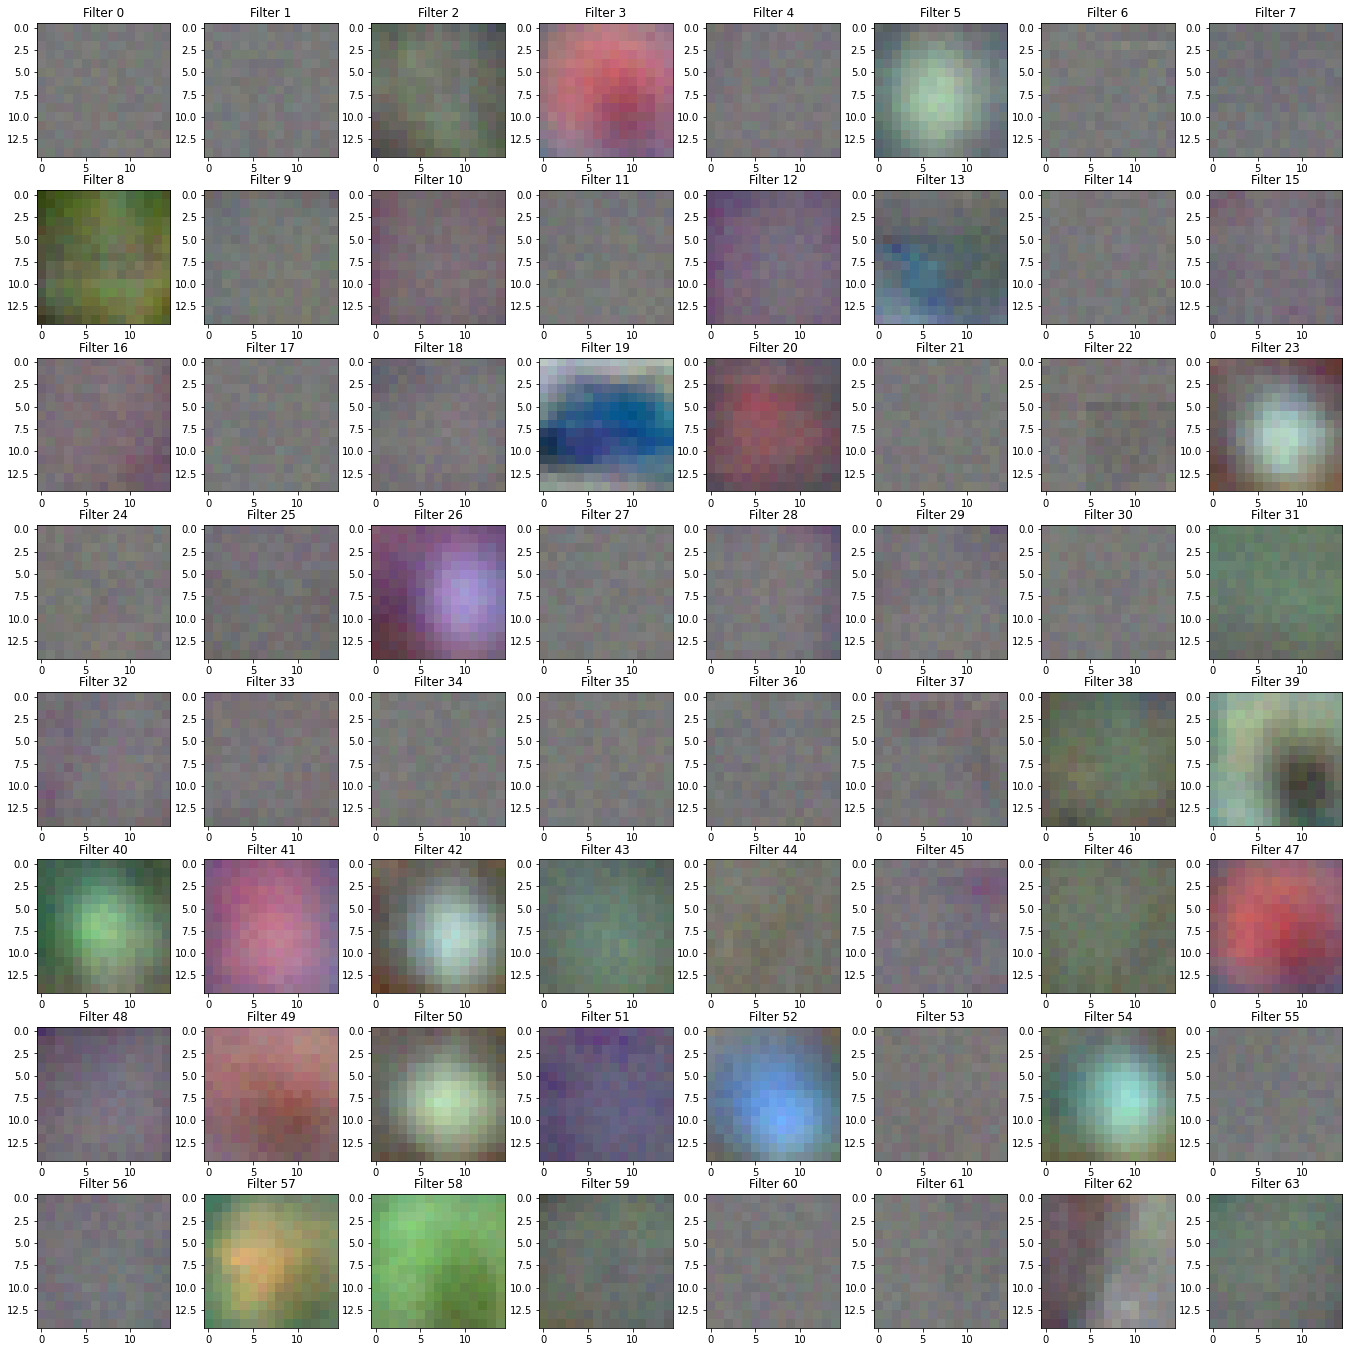

In [17]:
from sklearn.preprocessing import MinMaxScaler

cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]   #get the filters
wshape = W.shape  #save the original shape

# this part will scale to [0, 1] for visualization purposes
scaler = MinMaxScaler()
scaler.fit(W.reshape(-1,1))
W = scaler.transform(W.reshape(-1,1))
W = W.reshape(wshape)

fig, axs = plt.subplots(8,NUM_RECEPTIVE_FILTERS//8, figsize=(24,24))
fig.subplots_adjust(hspace = .25, wspace=.001)
axs = axs.ravel()
for i in range(W.shape[-1]):
  # we reshape to a 3D (RGB) image shape and display
  h = np.reshape(W[:,:,:,i], (GABOR_WIDTH,GABOR_HEIGHT,3))
  axs[i].imshow(h)
  axs[i].set_title('Filter ' + str(i))    
plt.savefig("caltech256-{}-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

-0.31676322 0.3399473


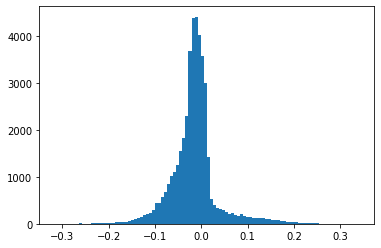

In [18]:
cnnl1 = classifier.layers[GABOR_LAYER_INDEX].name   # get the name of the first conv layer
W = classifier.get_layer(name=cnnl1).get_weights()[0]
plt.hist(W.ravel(), bins=100)
print(np.min(W),np.max(W))

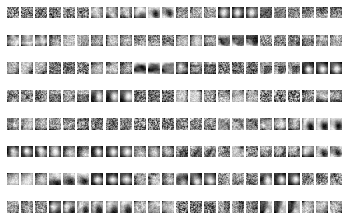

In [19]:
filter_layers = []
for i in range(NUM_RECEPTIVE_FILTERS):
    for j in range(3):
        filter_layers.append(np.reshape(W[:,:,j, i], GABOR_SIZE))
for i,gf in enumerate(filter_layers):
    plt.subplot(8, (W.shape[3]*3)//8, i+1)
    plt.imshow(gf, cmap='gray')
    plt.axis('off')
plt.savefig("caltech256-{}-channelwise-filters-kernel-{}.png".format(ITERATION,GABOR_WIDTH), bbox_inches='tight', dpi=350)

In [20]:
!cp caltech256-5-history-kernel-15.p /content/drive/My\ Drive/Mehang\ Rai/analysis/5/

In [21]:
!cp caltech256-5-loss-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/5/

In [22]:
!cp caltech256-5-accuracy-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/5/

In [23]:
!cp caltech256-5-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/5/

In [24]:
!cp caltech256-5-channelwise-filters-kernel-15.png /content/drive/My\ Drive/Mehang\ Rai/analysis/5/